# Adaptive QNN for Classifier

Created by Muhamad Akrom m.akrom@dsn.dinus.ac.id

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp
from qiskit.opflow import StateFn
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

/tmp/ipykernel_292923/553832105.py:12: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliSumOp
/tmp/ipykernel_292923/553832105.py:16: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


### 1. Load Dataset (Iris)

In [2]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

# Hanya gunakan class 0 dan 1
indexes = np.array([i for (i, s) in enumerate(y) if (s == 0 or s == 1)])
x = x[indexes]
y = 2 * y[indexes] - 1

### 2. Pre-processing

- EDA (skip)
- Normalization (skip)
- Cross-validation (skip), and others...

In [3]:
# Split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=0)

In [4]:
# Ofv

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### 3. Adaptive QNN Model

/tmp/ipykernel_292923/2351366065.py:4: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)
/tmp/ipykernel_292923/2351366065.py:25: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(circuit)
/tmp/ipykernel_292923/2351366065.py:25: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelin

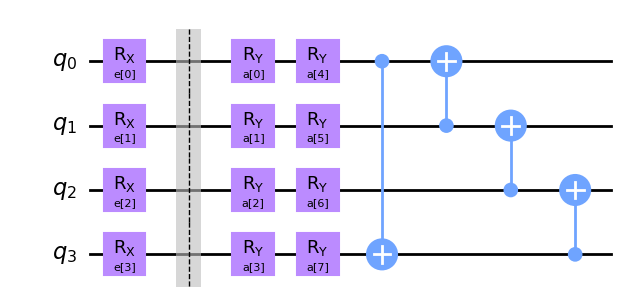

In [5]:
# Parameter
num_qubits       = x.shape[1]
backend          = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)
optimizer        = COBYLA(maxiter=100)
params_encoding  = ParameterVector('e', num_qubits)
params_ansatz    = ParameterVector('a', num_qubits * 2)
observable       = PauliSumOp.from_list([("ZIII", 1.0)])

circuit          = QuantumCircuit(num_qubits)

# Encoding
for i in range(num_qubits):
    circuit.rx(params_encoding[i], i)

circuit.barrier()

# Ansatz
for j in range(num_qubits * 2):
    circuit.ry(params_ansatz[j], j % num_qubits)
for k in range(num_qubits):
    circuit.cx(k, k-1)

# QNN classifier
qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(circuit)
estimator_qnn    = EstimatorQNN(
    circuit=circuit, 
    observables=observable, 
    input_params=params_encoding, 
    weight_params=params_ansatz
)
qnn = NeuralNetworkClassifier(
    estimator_qnn, optimizer=optimizer, loss='squared_error', callback=callback_graph
)

# Plot sirkuit
circuit.draw(output='mpl', style="clifford")

### 4. Training

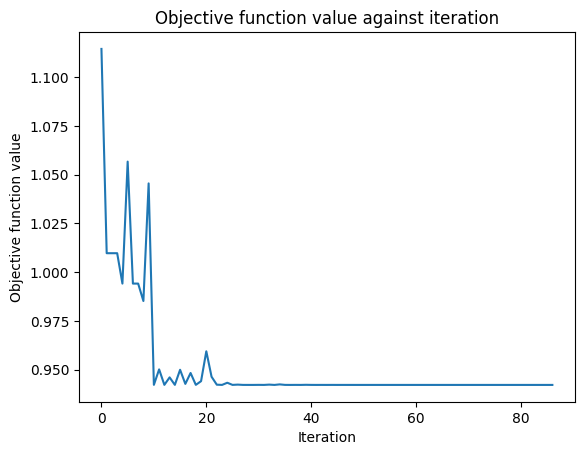

In [6]:
qnn.fit(x_train, y_train)

### 5. Evaluation

In [7]:
y_pred_tr = qnn.predict(x_train)
y_pred_ts = qnn.predict(x_test)

acc_tr = np.round(accuracy_score(y_train, y_pred_tr), 3)
acc_ts = np.round(accuracy_score(y_test, y_pred_ts), 3)
print("Accuracy Train :", acc_tr)
print("Accuracy Test  :", acc_ts)

Accuracy Train : 0.5
Accuracy Test  : 0.3
